Please enter the company's ticker symbol: APLE


[*********************100%%**********************]  1 of 1 completed


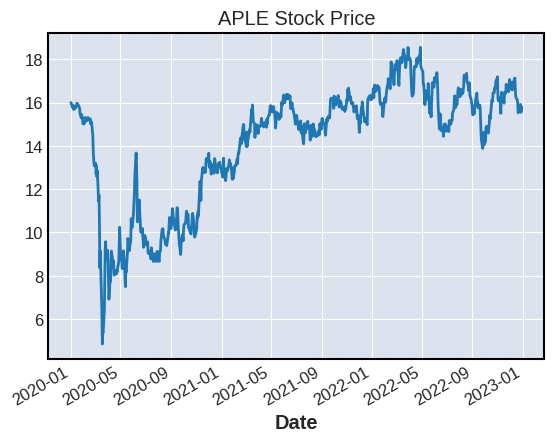

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


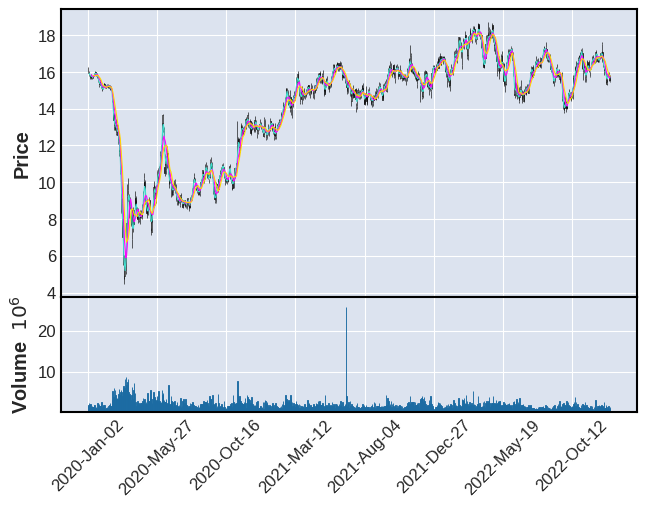

Epoch 1/25
22/22 [==============================] - 5s 45ms/step - loss: 0.0868
Epoch 2/25
22/22 [==============================] - 1s 46ms/step - loss: 0.0058
Epoch 3/25
22/22 [==============================] - 1s 47ms/step - loss: 0.0034
Epoch 4/25
22/22 [==============================] - 1s 50ms/step - loss: 0.0027
Epoch 5/25
22/22 [==============================] - 1s 51ms/step - loss: 0.0025
Epoch 6/25
22/22 [==============================] - 1s 61ms/step - loss: 0.0024
Epoch 7/25
22/22 [==============================] - 2s 78ms/step - loss: 0.0023
Epoch 8/25
22/22 [==============================] - 2s 77ms/step - loss: 0.0024
Epoch 9/25
22/22 [==============================] - 1s 46ms/step - loss: 0.0024
Epoch 10/25
22/22 [==============================] - 1s 46ms/step - loss: 0.0023
Epoch 11/25
22/22 [==============================] - 1s 46ms/step - loss: 0.0023
Epoch 12/25
22/22 [==============================] - 1s 49ms/step - loss: 0.0023
Epoch 13/25
22/22 [==================

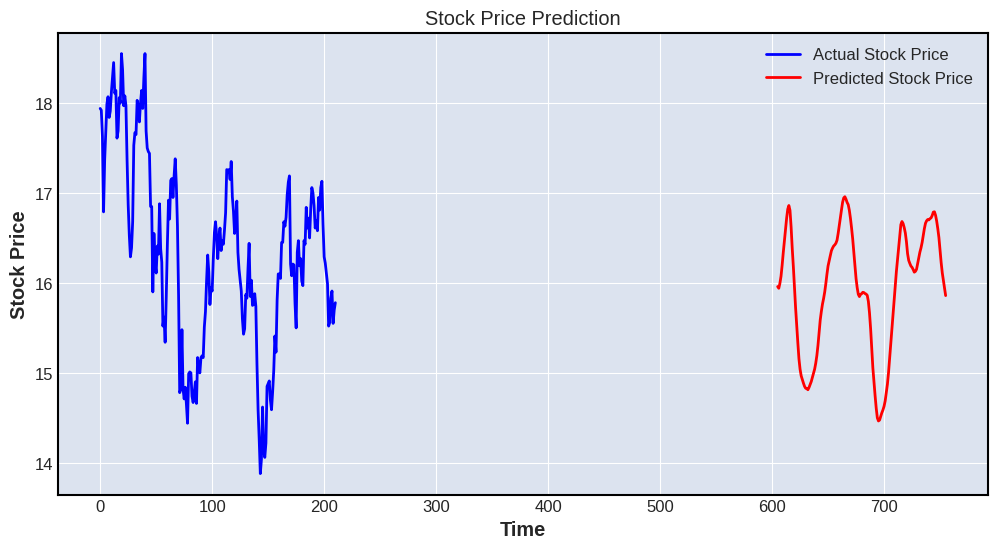

Mean Squared Error: 0.39093917049472987


In [7]:
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Provide Inputs
company = input("Please enter the company's ticker symbol: ")

# Fetch historical data
data = yf.download(company, '2020-01-01', '2022-12-31')
data = data.drop('Adj Close', axis=1)
data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Plot closing prices
data['Close'].plot()
plt.title(f'{company} Stock Price')
plt.show()

# Plot OHLC data as a candlestick chart
mpf.plot(data, type='candle', mav=(3, 6, 9), volume=True)

# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create sequences for training
prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

# Prepare the test data
test_data = data['Close'][-(len(data) // 5 + prediction_days):].values
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))
x_test = []
y_test = test_data[prediction_days:]

for x in range(prediction_days, len(scaled_test_data)):
    x_test.append(scaled_test_data[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data['Close'].values[-len(test_data):], color='blue', label='Actual Stock Price')
plt.plot(range(len(data) - len(test_data) + prediction_days, len(data)), predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, predicted_prices)
print(f'Mean Squared Error: {mse}')
